# Customer Churn Prediction

### Customer demographic info
- customerID: Customer ID
- gender: Whether the customer is a male or a female
- SeniorCitizen: Whether the customer is a senior citizen or not (1, 0)
- Partner: Whether the customer has a partner or not (Yes, No)
- Dependents: Whether the customer has dependents or not (Yes, No)

### Signed up services
- PhoneService: Whether the customer has a phone service or not (Yes, No)
- MultipleLines: Whether the customer has multiple lines or not (Yes, No, No phone service)
- InternetService: Customer’s internet service provider (DSL(Digital Subscriber Line), Fiber optic, No)
- OnlineSecurity: Whether the customer has security or not (Yes, No, No internet service)
- OnlineBackup:Whether the customer has online backup or not (Yes, No, No internet service)
- DeviceProtection: Whether the customer has device protection or not (Yes, No, No internet service)
- TechSupport: Whether the customer has tech support or not (Yes, No, No internet service)
- StreamingTV: Whether the customer has streaming TV or not (Yes, No, No internet service)
- StreamingMovies: Whether the customer has streaming movies or not (Yes, No, No internet service)

### Customer account information
- tenure: Number of months the customer has stayed with the company
- Contract: The contract term of the customer (Month-to-month, One year, Two year)
- PaperlessBilling: Whether the customer has paperless billing or not (Yes, No)
- PaymentMethod: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card
- MonthlyCharges: The amount charged to the customer monthly
- TotalCharges: The total amount charged to the customer

### Customer left within the last month
- Churn: Whether the customer churned or not (Yes or No)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
customer_churn = pd.read_csv('CustomerChurn.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'CustomerChurn.csv'

In [ ]:
customer_churn.head()

In [ ]:
#checking data type
customer_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
#totalcharges should be numerical rather than object, convert it into float64; and checking missing values
customer_churn['TotalCharges'] = pd.to_numeric(customer_churn['TotalCharges'], errors = 'coerce')
customer_churn.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [ ]:
#impute median with totalcharges missing value
customer_churn['TotalCharges'] = customer_churn['TotalCharges'].fillna(customer_churn['TotalCharges'].median())
customer_churn.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
#drop CustomerID column
customer_churn = customer_churn.drop(columns=['customerID'])

In [ ]:
# Adjust inconsistencies
# Replace "No phone service" with "No" in the MultipleLines column
customer_churn['MultipleLines'] = customer_churn['MultipleLines'].replace('No phone service', 'No')

#Replace "No internet service" with "No"
internet_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in internet_columns:
    customer_churn[col] = customer_churn[col].replace('No internet service', 'No')

#convert "Partner", "Dependents", "Churn", "PaperlessBilling" to binary
binary_columns = ['Partner', 'Dependents', 'Churn', 'PaperlessBilling']
for col in binary_columns:
    customer_churn[col] = customer_churn[col].map({'Yes': 1, 'No': 0})

customer_churn.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,0,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


Number of outliers in tenure: 0
Number of outliers in MonthlyCharges: 0
Number of outliers in TotalCharges: 0


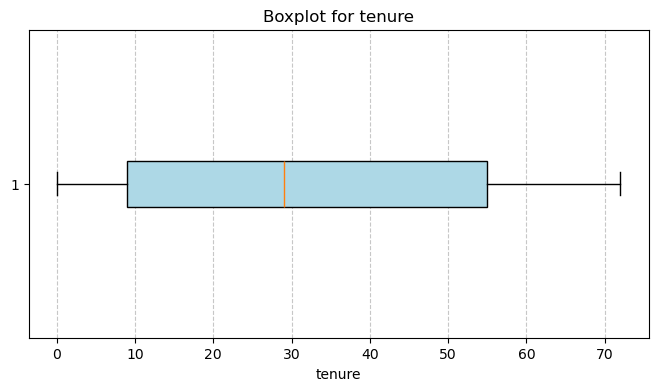

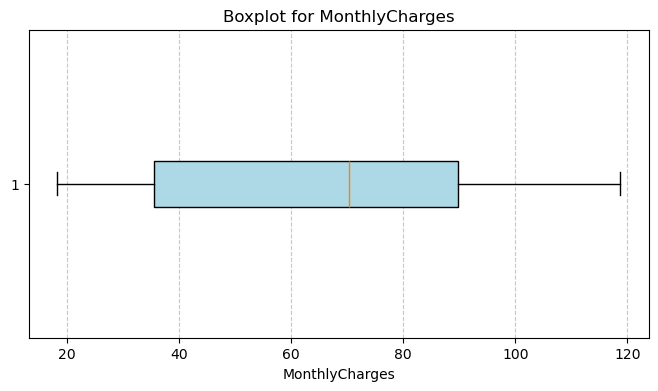

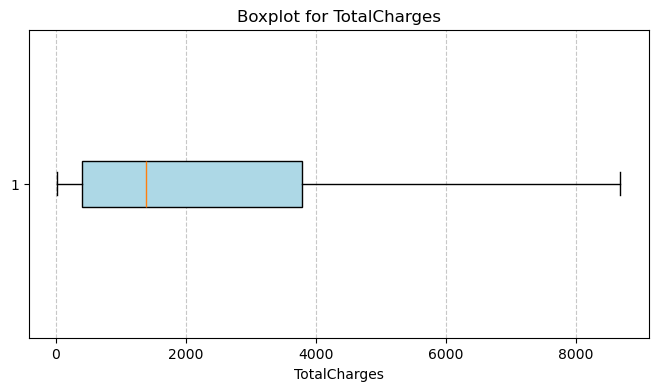

In [ ]:
#use IQR and boxplot to detect outliers for numerical columns
def detect_outliers_iqr(customer_churn, column):
    Q1 = customer_churn[column].quantile(0.25)
    Q3 = customer_churn[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = customer_churn[(customer_churn[column] < lower_bound) | (customer_churn[column] > upper_bound)]
    return outliers

columns_to_check = ['tenure', 'MonthlyCharges', 'TotalCharges']
outliers_results = {}
for col in columns_to_check:
    outliers_results[col] = detect_outliers_iqr(customer_churn, col)

for col in columns_to_check:
    print(f"Number of outliers in {col}: {len(outliers_results[col])}")
    if not outliers_results[col].empty:
        print(f"Sample outliers in {col}:\n{outliers_results[col].head()}")

for col in columns_to_check:
    plt.figure(figsize=(8, 4))
    plt.boxplot(customer_churn[col], vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
    plt.title(f'Boxplot for {col}')
    plt.xlabel(col)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

### EDA: Analyze customer demographics, account features, and usage patterns to identify churn trends
### 1. Customer Demographics
- Gender: The churn rates for male and female customers are very similar, indicating that gender is not a significant factor in determining churn behavior.
- Senior Citizens: Senior citizens have a higher probability of churning, even though they constitute a smaller fraction of the customer base.
- Dependents and Partners: Customers without dependents or partners are more likely to churn. This suggests that individuals may find it easier to switch service providers.

### 2. Account Features
- Contract Type: Customers with month-to-month contracts have significantly higher churn rates compared to longer contracts.
- Paperless billing: Customers with paperless billing show a higher churn rate, possibly indicating dissatisfaction with digital processes.
- Payment Methods: Customers paying via electronic check are the most likely to churn.
- Tenure: Customers with short tenure (<10 months) are more likely to churn, indicating the importance of onboarding and early engagement strategies.
- Monthly charges and Total charges: The customers having higher monthly charges and total chargesare are more likely to churn.

### 3. Usage Patterns
- Phone Service and Multiple Lines: Customers with phone service are more likely to churn, especially when they have multiple lines.
- Internet Service: Fiber optic users churn more compared to DSL and those without internet service.
- Tech Support and Online Security: Customers lacking technical support and online security churn at higher rates.
- Streaming Services (TV and Movies): Customers subscribed to streaming services (both TV and movies) are slightly more likely to churn. This could indicate a mismatch between the offered services and customer expectations.

In [ ]:
# Summary statistics
customer_churn.describe()

,SeniorCitizen,Partner,Dependents,tenure,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,0.483033,0.299588,32.371149,0.592219,64.761692,2281.916928,0.265370
std,0.368612,0.499748,0.458110,24.559481,0.491457,30.090047,2265.270398,0.441561
min,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,0.000000,0.000000,9.000000,0.000000,35.500000,402.225000,0.000000
50%,0.000000,0.000000,0.000000,29.000000,1.000000,70.350000,1397.475000,0.000000
75%,0.000000,1.000000,1.000000,55.000000,1.000000,89.850000,3786.600000,1.000000
max,1.000000,1.000000,1.000000,72.000000,1.000000,118.750000,8684.800000,1.000000


1. Customer Demographics
Senior citizens: Only about 16% of the customers are senior citizens.
Partner: Approximately half of the customers have a partner.
Dependents: About 30% of the customers have dependents.
2. Account Features
Tenure: Mean tenure is 32.37 months.
Paperless billing: Around 59% of customers opt for paperless billing.
3. Usage Patterns
Monthly Charges (Mean: 64.76):
Total Charges (Mean: 2281.92)

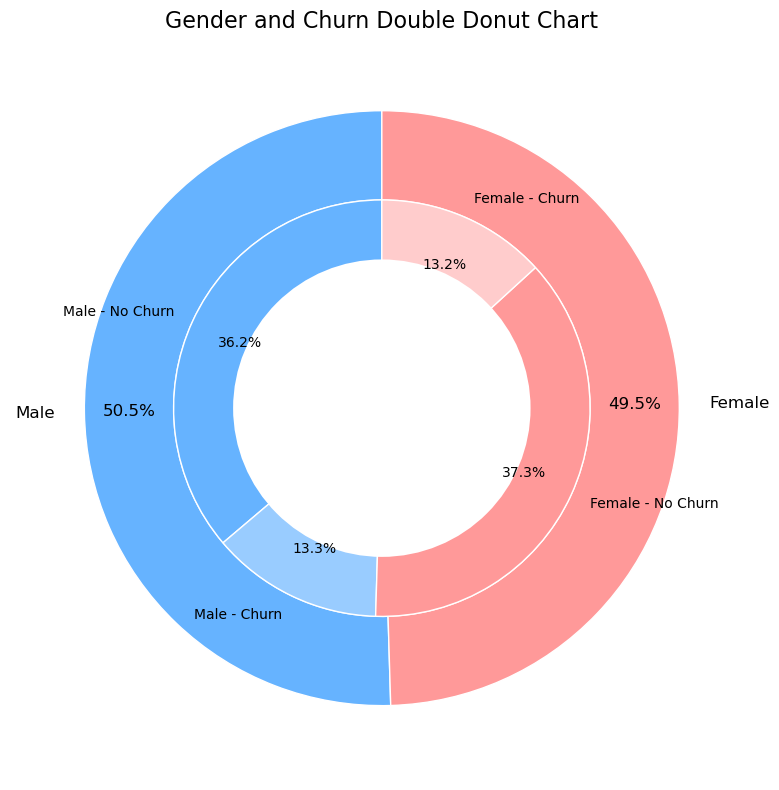

In [ ]:
# Group data by gender and churn
gender_churn = customer_churn.groupby(['gender', 'Churn']).size().unstack()
gender_total = customer_churn['gender'].value_counts()

# Calculate percentages
gender_churn_rate = gender_churn.div(gender_total, axis=0) * 100  # Churn rate within each gender

# Outer ring (gender distribution)
outer_sizes = gender_total.values  # Total counts of Male and Female
outer_labels = gender_total.index  # Male and Female labels

# Inner ring (churn and no churn distribution within each gender)
inner_sizes = gender_churn.values.flatten()  # Values for Male-No, Male-Yes, Female-No, Female-Yes
inner_labels = ['Male - No Churn', 'Male - Churn', 'Female - No Churn', 'Female - Churn']

# Colors for the rings
outer_colors = ['#66b3ff', '#ff9999']  # Colors for Male and Female
inner_colors = ['#66b3ff', '#99ccff', '#ff9999', '#ffcccc']  # Colors for churn breakdown

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Outer ring
ax.pie(
    outer_sizes,
    radius=1,
    labels=outer_labels,
    colors=outer_colors,
    startangle=90,
    wedgeprops=dict(width=0.3, edgecolor='w'),
    autopct='%1.1f%%',
    pctdistance=0.85,
    textprops={'fontsize': 12}
)

# Inner ring
ax.pie(
    inner_sizes,
    radius=0.7,
    labels=inner_labels,
    colors=inner_colors,
    startangle=90,
    wedgeprops=dict(width=0.3, edgecolor='w'),
    autopct='%1.1f%%',
    pctdistance=0.75,
    textprops={'fontsize': 10}
)

# Add a white circle at the center
centre_circle = plt.Circle((0, 0), 0.5, fc='white')
fig.gca().add_artist(centre_circle)

# Add title
plt.title('Gender and Churn Double Donut Chart', fontsize=16)
plt.tight_layout()
plt.show()

The data is balanced in terms of gender

The churn rates for male and female customers are very similar, so gender does not play a significant role in determining churn behavior

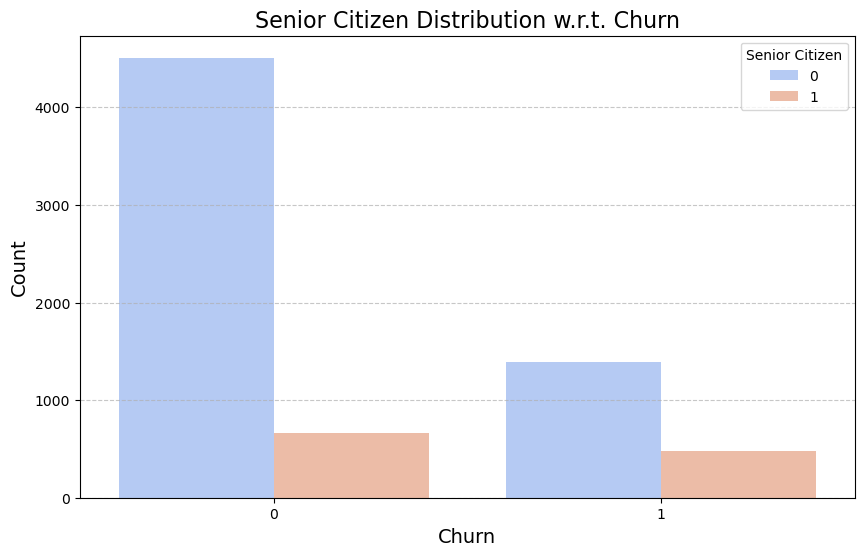

In [ ]:
# Analysis between seniorcitizen and churn
plt.figure(figsize=(10, 6))
sns.countplot(
    data=customer_churn,
    x='Churn',
    hue='SeniorCitizen',
    palette='coolwarm',
    dodge=True
)
plt.title('Senior Citizen Distribution w.r.t. Churn', fontsize=16)
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Senior Citizen')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

the fraction of senior citizen is very less

Senior citizen have higher probability to churn

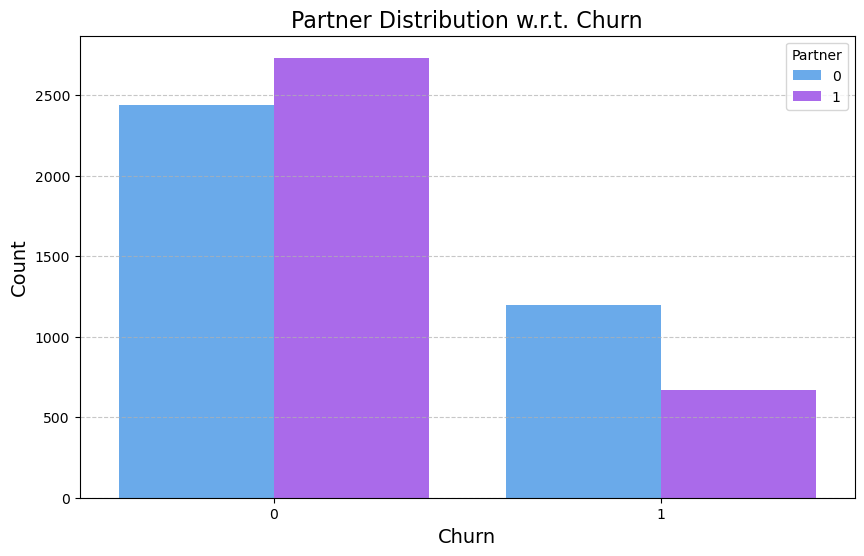

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=customer_churn,
    x='Churn',
    hue='Partner',
    palette='cool',
    dodge=True
)
plt.title('Partner Distribution w.r.t. Churn', fontsize=16)
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Partner')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The customers without partner are more likely to churn

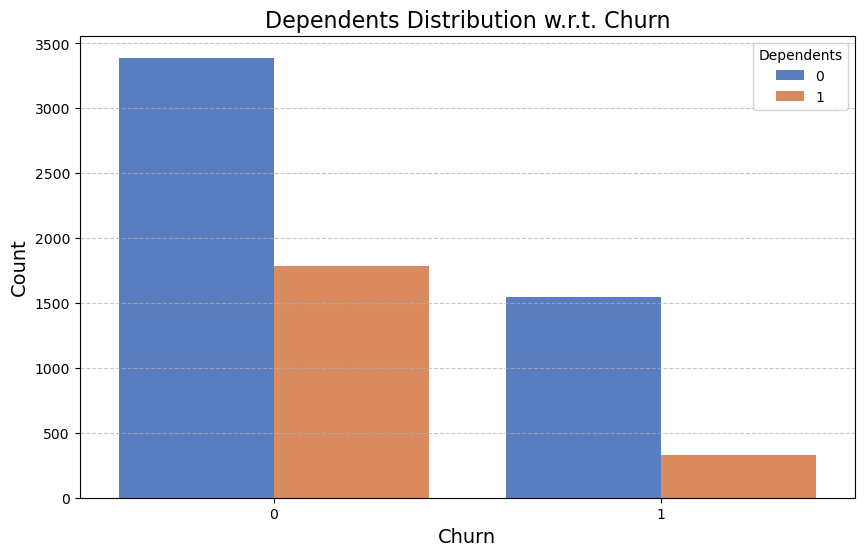

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=customer_churn,
    x='Churn',
    hue='Dependents',
    palette='muted',
    dodge=True
)
plt.title('Dependents Distribution w.r.t. Churn', fontsize=16)
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Dependents')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Customers without dependents are more likely to churn

Summarize the two histogram, single customers (no dependents, no partner) are more likely to churn

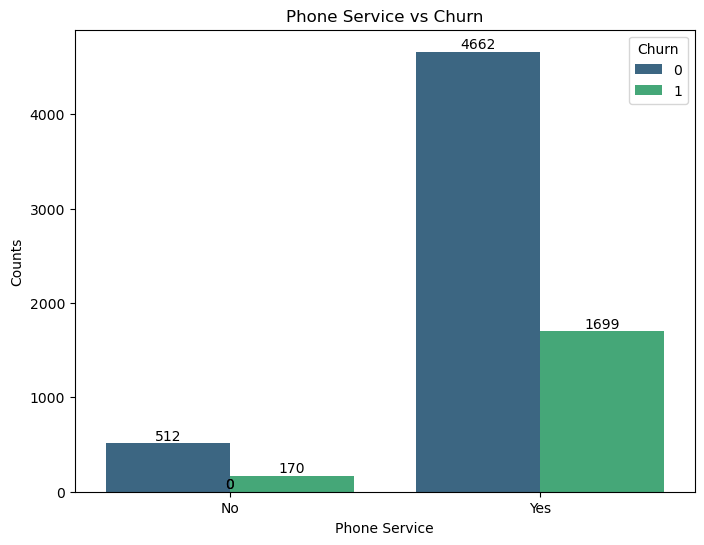

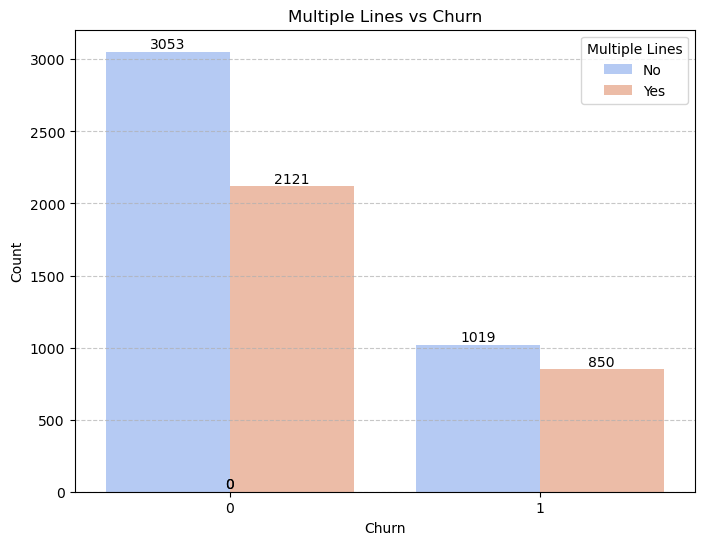

In [ ]:
# Identify whether having a phone service correlates with churn, and check if having multiple lines affects churn
# Annotated bar chart for Phone Service vs Churn
phone_churn = customer_churn.groupby(['PhoneService', 'Churn']).size().reset_index(name='counts')

plt.figure(figsize=(8, 6))
barplot = sns.barplot(x='PhoneService', y='counts', hue='Churn', data=phone_churn, palette='viridis')
plt.title('Phone Service vs Churn')
plt.xlabel('Phone Service')
plt.ylabel('Counts')
plt.legend(title='Churn')

# Annotate values on the bars
for bar in barplot.patches:
    barplot.annotate(format(bar.get_height(), '.0f'),
                     (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                     ha='center', va='bottom', fontsize=10)
plt.show()

# Annotated bar chart for Multiple Lines vs Churn
plt.figure(figsize=(8, 6))
countplot = sns.countplot(x='Churn', hue='MultipleLines', data=customer_churn, palette='coolwarm')
plt.title('Multiple Lines vs Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.legend(title='Multiple Lines')

# Annotate values on the bars
for bar in countplot.patches:
    countplot.annotate(format(bar.get_height(), '.0f'),
                       (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                       ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Very small fraction of customers don't have a phone service.

Customers with phone service are more likely to churn, especially when they have multiple lines: When cusotmers don't have ohone service, the churn rate is 24.9%; when customers have service, the churn rate is 26.7%, under this circumstance, if they have single line, their churn rate is 25%, but if they have multiple lines, their churn rate is 28.6%.

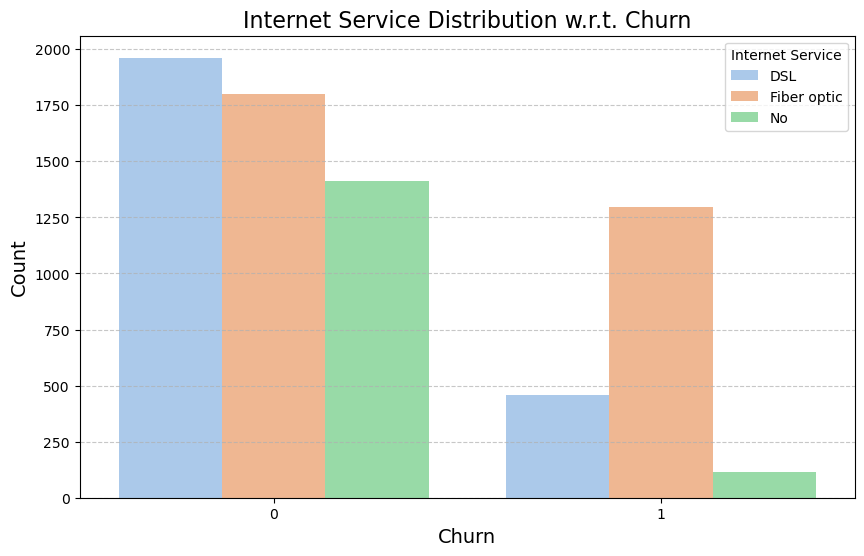

In [ ]:
# intenet and service
plt.figure(figsize=(10, 6))
sns.countplot(
    data=customer_churn,
    x='Churn',
    hue='InternetService',
    palette='pastel',
    dodge=True
)
plt.title('Internet Service Distribution w.r.t. Churn', fontsize=16)
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Internet Service')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Customers choosing Fiber optic are the majority, but customers who use Fiber optic have high churn rate, this might suggest a dissatisfaction with this type of internet service.

Customers having DSL service have less churn rate compared to fiber optic service

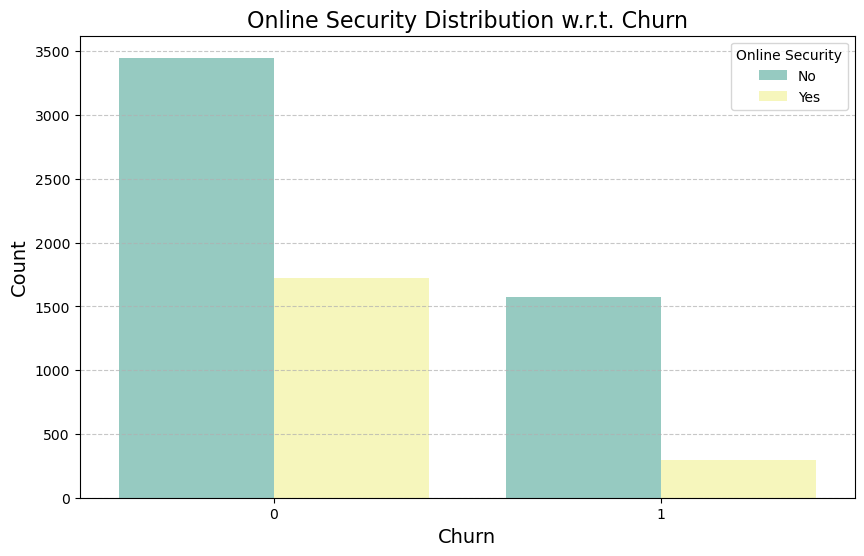

In [ ]:
# visualize the Online Security feature and churn
plt.figure(figsize=(10, 6))
sns.countplot(
    data=customer_churn,
    x='Churn',
    hue='OnlineSecurity',
    palette='Set3',
    dodge=True
)
plt.title('Online Security Distribution w.r.t. Churn', fontsize=16)
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Online Security')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Customers without online security are more likely to churn

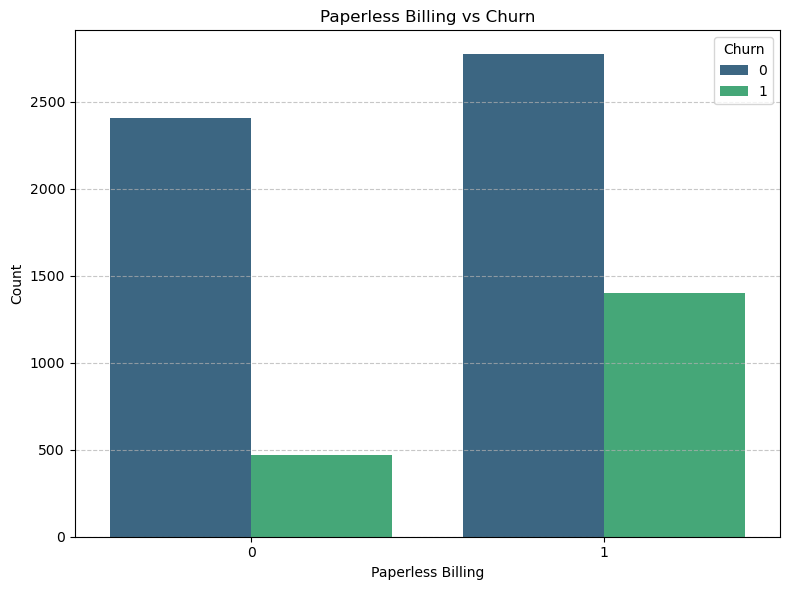

In [ ]:
# Group data by Paperless Billing and Churn
paperless_data = customer_churn.groupby(['PaperlessBilling', 'Churn']).size().reset_index(name='Count')

# Create a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='PaperlessBilling', y='Count', hue='Churn', data=paperless_data, palette='viridis')
plt.title('Paperless Billing vs Churn')
plt.xlabel('Paperless Billing')
plt.ylabel('Count')
plt.legend(title='Churn')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Higher proportion of customers with Paperless Billing churn compared to those without Paperless Billing, indicating dissatisfaction with the convenience or user experience associated with Paperless Billing

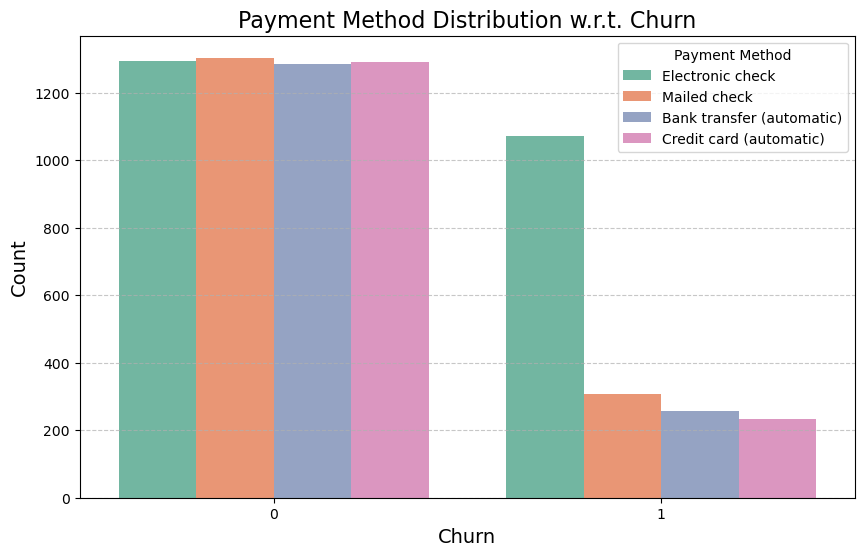

In [ ]:
# Payment method and churn
plt.figure(figsize=(10, 6))
sns.countplot(
    data=customer_churn,
    x='Churn',
    hue='PaymentMethod',
    palette='Set2',
    dodge=True
)
plt.title('Payment Method Distribution w.r.t. Churn', fontsize=16)
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Payment Method')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Customers using electronic check are more likely to churn in terms of payment method

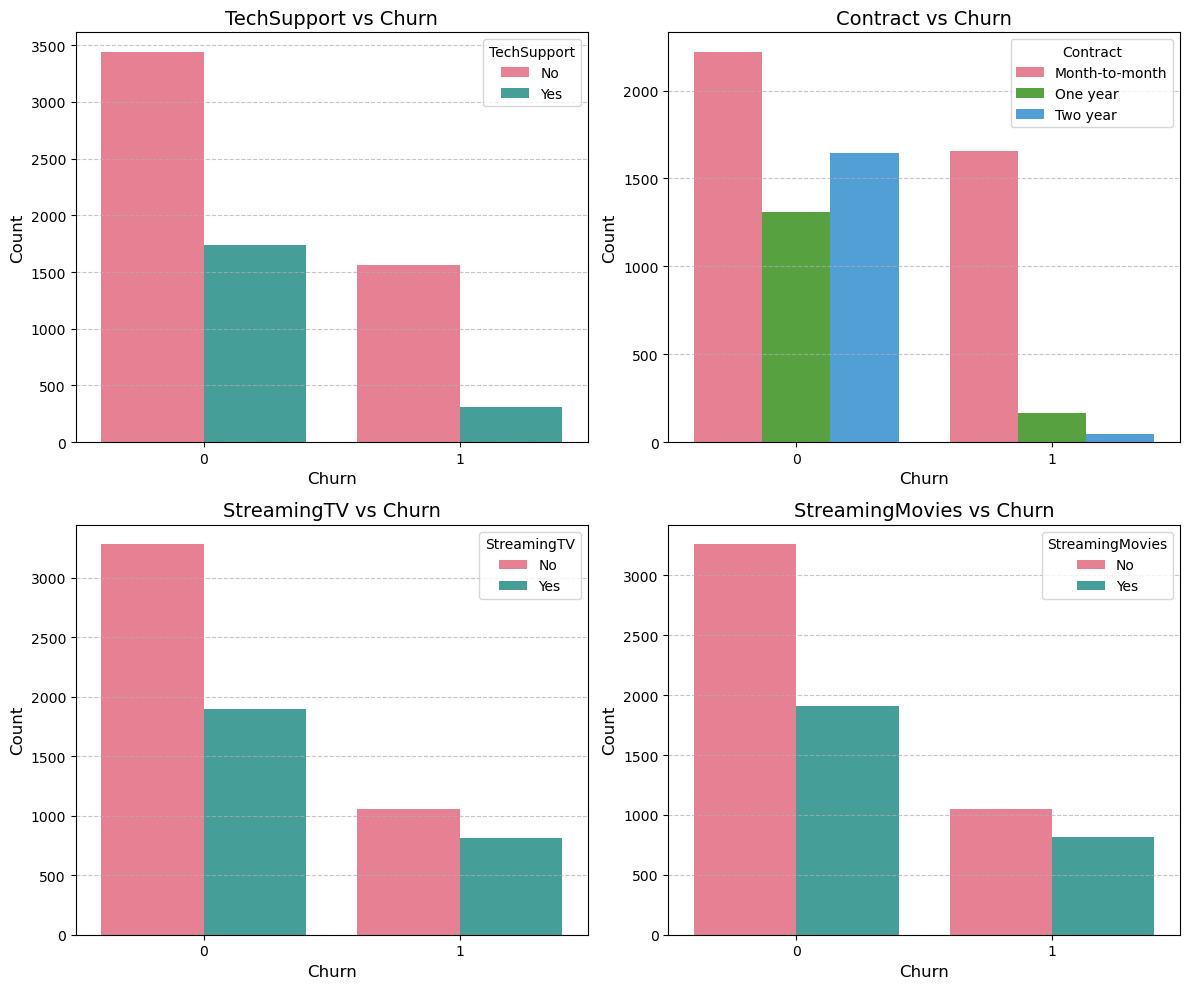

In [ ]:
# Consolidated Analysis for Streaming Services, Contract, and TechSupport
features_to_plot = ['TechSupport', 'Contract', 'StreamingTV', 'StreamingMovies']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    sns.countplot(ax=axes[i], x='Churn', hue=feature, data=customer_churn, palette='husl')
    axes[i].set_title(f'{feature} vs Churn', fontsize=14)
    axes[i].set_xlabel('Churn', fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].legend(title=feature)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

1. Customers without tech support are most likely to migrate to another service provider
2. Month-to-month contracts have higher churn compared to longer-term contracts. About 89% of customer with Month-to-Month Contract move out to another providers as compared to 9% of customrs with One Year Contract and 2.6% with Two Year Contract
3. Customers with streaming TV and streaming movies are more likely to churn

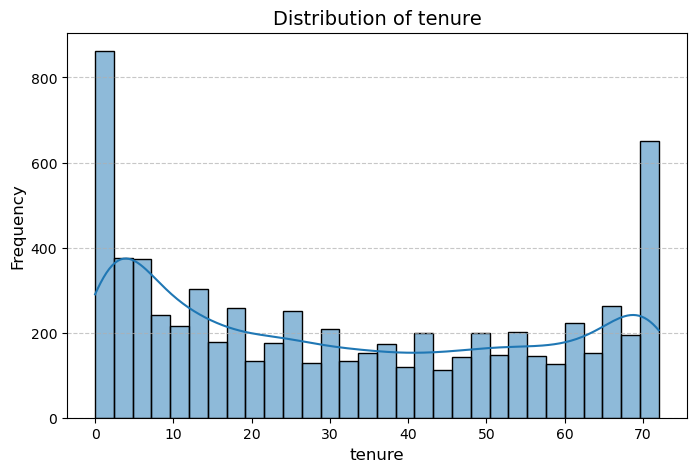

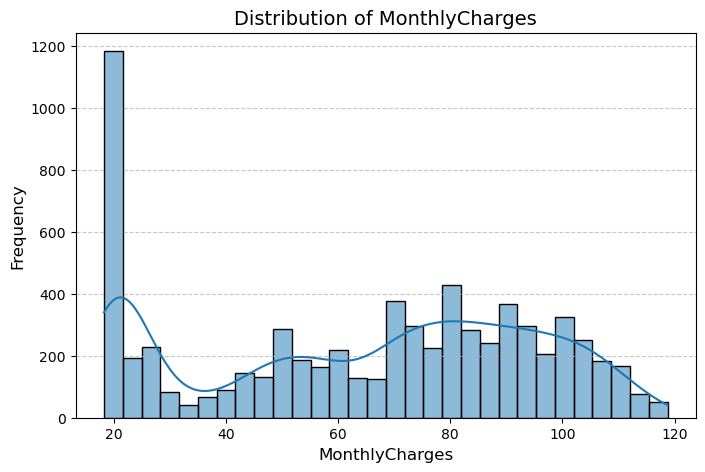

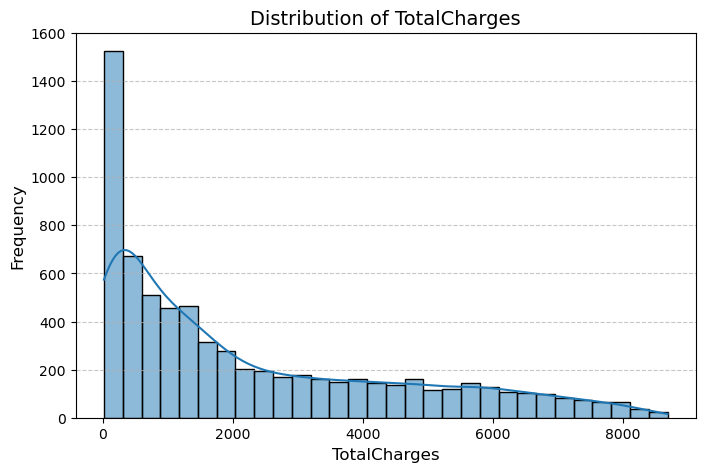

In [ ]:
# Plot histograms and box plots to understand the distribution of numerical features

# Numerical features to visualize
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Plot histograms for numerical features
for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(customer_churn[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

1. Tenure Distribution: This distribution is bimodal, with peaks at the low and high tenure ranges. The middle range (20–50 months) has relatively even and lower frequency, fewer customers in this tenure range.
2. Monthly charges: The distribution is slightly right-skewed. There is a concentration around 20-30 and 70-100, this indicates most customers have lower monthly charges, but there is a segment paying higher fees.
3. Total charges: Heavily concentrated at the lower range around 0–500. The distribution is right-skewed, showing a clear long tail extending toward very high TotalCharges

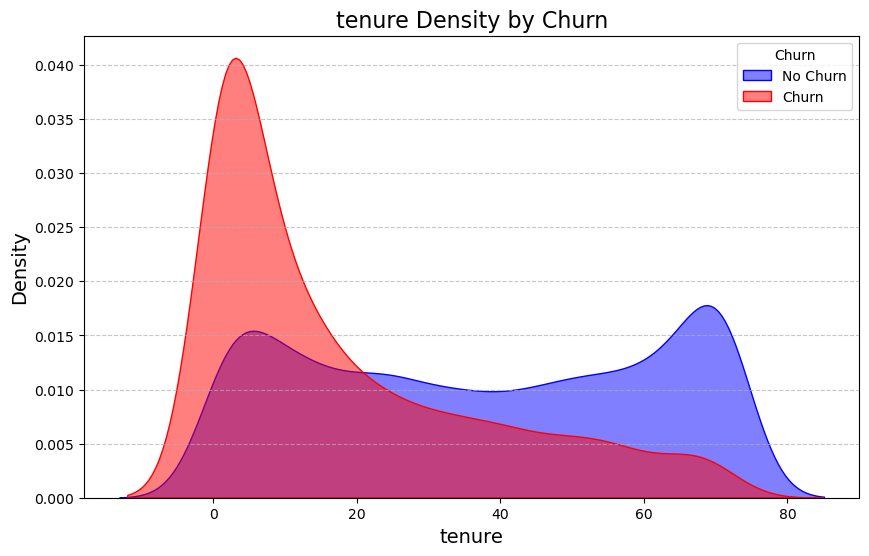

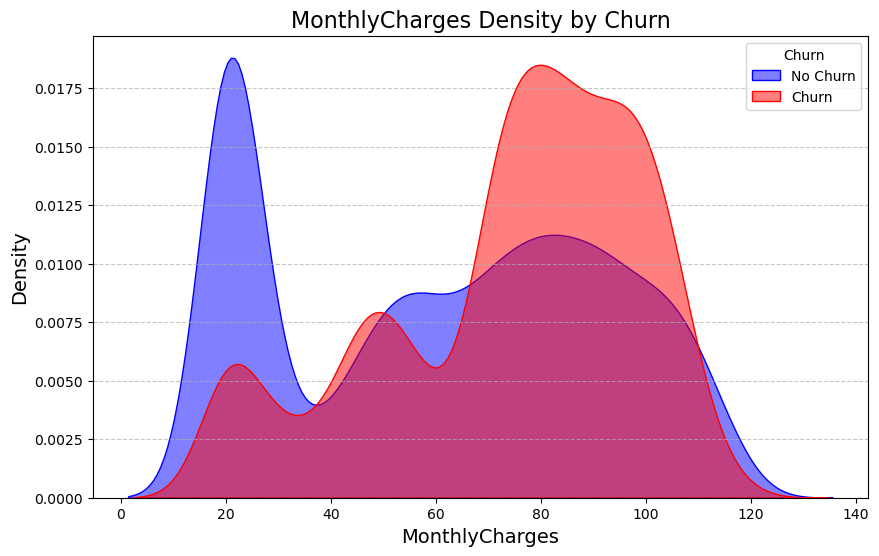

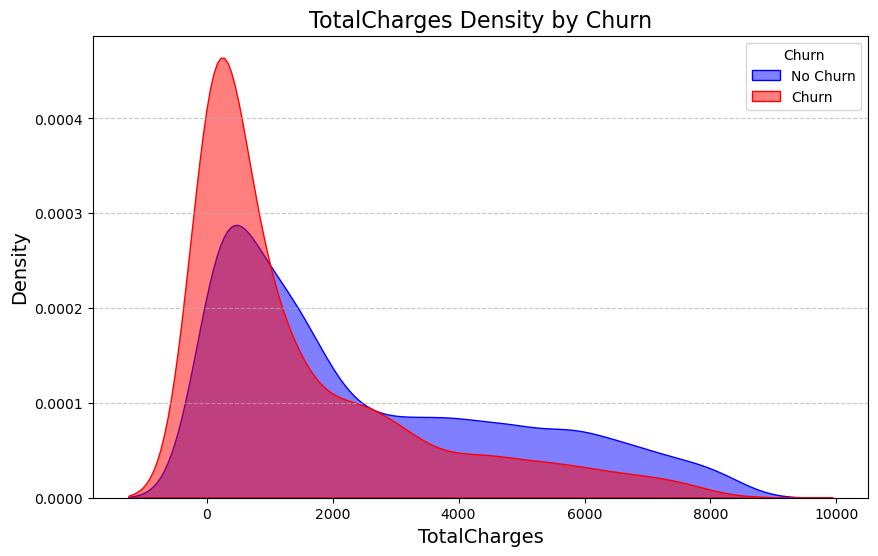

In [ ]:
# Examine relationships between numerical features and churn
for feature in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(
        data=customer_churn[customer_churn['Churn'] == 0],
        x=feature,
        fill=True,
        label='No Churn',
        color='blue',
        alpha=0.5
    )
    sns.kdeplot(
        data=customer_churn[customer_churn['Churn'] == 1],
        x=feature,
        fill=True,
        label='Churn',
        color='red',
        alpha=0.5
    )
    plt.title(f'{feature} Density by Churn', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(title='Churn')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

1. New customers are more likely to churn: Most churn happens with customers having very short tenures (less than 10 months)
2. The customers charger higher monthly are more likely to churn, with the highest density observed between $70 and $100
3. Customers with higher total charges are more likely to churn:the density is higher for lower total charges (below $1,000)

Model Selection: Logistic Regression
Why Logistic Regression?
It is a straightforward and interpretable classification model.
Suitable for binary classification problems like churn prediction.
Allows for easy calculation of probabilities and odds ratios, which can provide actionable business insights.
Evaluation Metric: Use accuracy, precision, recall, F1-score, and ROC-AUC to evaluate model performance.

The data contains non-numeric values (e.g., categorical variables like 'Female') that need to be converted to numeric format before being scaled.
1. Identify Non-Numeric Columns Check which columns contain non-numeric data

In [ ]:
# Assuming df is your dataframe and 'Churn' is your target column
X = customer_churn.drop(columns=['Churn'])
y = customer_churn['Churn']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.dtypes)


gender               object
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling      int64
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object


Convert Categorical Data to Numeric using one-hot encoding.
One-Hot Encoding: Creates binary columns for each category. For example, 'Gender' with values 'Male' and 'Female' becomes a single column like 'Gender_Male' (0 or 1).

In [ ]:
import statsmodels.api as sm

# Apply one-hot encoding to categorical columns
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns in X_test with X_train (ensures the same columns in both datasets)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Convert all boolean columns to integer format
X_train = X_train.astype(int)
X_test = X_test.astype(int)


In [ ]:
#Check Encoding
print(X_train.dtypes)


SeniorCitizen                            int64
Partner                                  int64
Dependents                               int64
tenure                                   int64
PaperlessBilling                         int64
MonthlyCharges                           int64
TotalCharges                             int64
gender_Male                              int64
PhoneService_Yes                         int64
MultipleLines_Yes                        int64
InternetService_Fiber optic              int64
InternetService_No                       int64
OnlineSecurity_Yes                       int64
OnlineBackup_Yes                         int64
DeviceProtection_Yes                     int64
TechSupport_Yes                          int64
StreamingTV_Yes                          int64
StreamingMovies_Yes                      int64
Contract_One year                        int64
Contract_Two year                        int64
PaymentMethod_Credit card (automatic)    int64
PaymentMethod

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled[:5])  # First 5 rows of scaled training data
print(X_test_scaled[:5])   # First 5 rows of scaled testing data



[[-0.4377492  -0.96957859  1.53218588 -0.46568336 -1.20000722 -0.01322033
  -0.42149069 -1.02516569  0.32957344 -0.86052337 -0.88705673 -0.52408075
   1.5809424  -0.73382801  1.38479574 -0.63776294 -0.79474818  1.25076217
   1.9101086  -0.55835281 -0.52765585 -0.70964983  1.84247002]
 [-0.4377492  -0.96957859 -0.65266232  0.88553679  0.83332832  1.08358885
   1.25589917 -1.02516569  0.32957344  1.16208349  1.12732361 -0.52408075
  -0.63253411  1.36271713 -0.72212816 -0.63776294  1.25826019  1.25076217
  -0.52353044  1.79098231 -0.52765585 -0.70964983 -0.54274967]
 [-0.4377492   1.03137591 -0.65266232 -1.28460467  0.83332832 -1.37592263
  -1.00214266  0.97545208 -3.03422506 -0.86052337 -0.88705673 -0.52408075
  -0.63253411 -0.73382801 -0.72212816 -0.63776294 -0.79474818 -0.79951251
  -0.52353044 -0.55835281 -0.52765585  1.40914569 -0.54274967]
 [-0.4377492  -0.96957859 -0.65266232 -1.16176647  0.83332832  0.18619952
  -0.90750479  0.97545208  0.32957344 -0.86052337  1.12732361 -0.524080

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the logistic regression model
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# Extract coefficients and intercept
coefficients = model.coef_[0]   # Coefficients for each feature
intercept = model.intercept_[0]

# Calculate odds ratios
odds_ratios = np.exp(coefficients)

predicted_probabilities = odds_ratios / (1 + odds_ratios)

# Combine feature names, coefficients, and odds ratios into a table
feature_names = X_train.columns  # Names of features used in the model
coefficients_table = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios,
    'Predicted Probability':  predicted_probabilities # Repeat for each feature
}).sort_values(by='Odds Ratio', ascending=False)  # Sort by odds ratio

# Display the table
print("\nCoefficients and Odds Ratios:")
coefficients_table



Coefficients and Odds Ratios:


,Feature,Coefficient,Odds Ratio,Predicted Probability
6,TotalCharges,0.623635,1.865698,0.651045
10,InternetService_Fiber optic,0.532133,1.702560,0.629981
17,StreamingMovies_Yes,0.194683,1.214926,0.548518
4,PaperlessBilling,0.163782,1.177958,0.540854
21,PaymentMethod_Electronic check,0.152621,1.164884,0.538081
9,MultipleLines_Yes,0.151060,1.163067,0.537693
16,StreamingTV_Yes,0.144517,1.155482,0.536067
0,SeniorCitizen,0.058474,1.060218,0.514614
1,Partner,0.027348,1.027725,0.506836
14,DeviceProtection_Yes,0.011120,1.011182,0.502780


Confusion Matrix:
[[933 103]
 [149 224]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409


ROC-AUC Score: 0.86


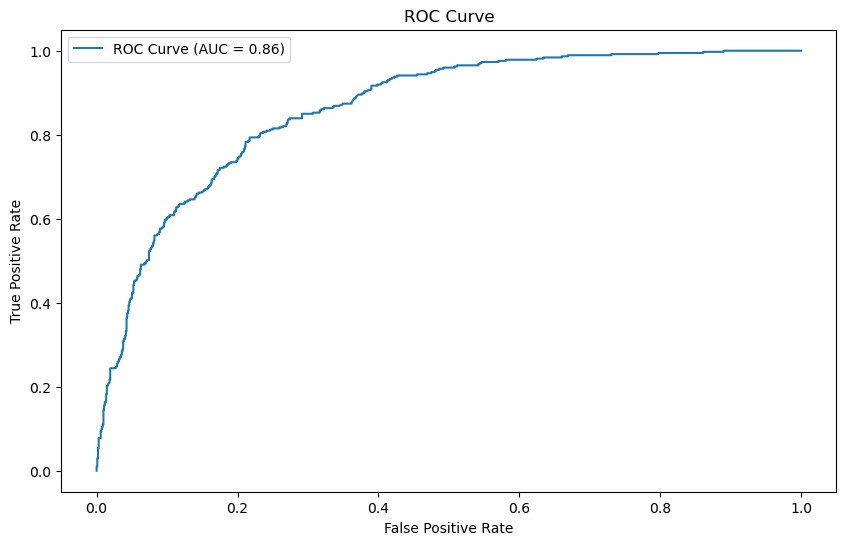

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


From the output of logistic regression model, here are the key takeaways:

Confusion Matrix
True Positives (TP): 224 - Correctly predicted customers who churned.
True Negatives (TN): 933 - Correctly predicted customers who did not churn.
False Positives (FP): 149 - Predicted customers would churn, but they did not.
False Negatives (FN): 103 - Predicted customers would not churn, but they did.

Classification Report

Precision:
For class 0 (not churn): 0.86- 86% of predicted "not churn" customers were correct.
For class 1 (churn): 0.69- 69% of predicted "churn" customers were correct.
Indicates that the model is better at identifying non-churners compared to churners.

Recall:
For class 0 (not churn): 0.90. The model identified 90% of actual "not churn" customers.
For class 1 (churn): 0.60.The model identified 60% of actual "churn" customers.
Suggests that the model struggles to catch all churners.

F1-Score:
F1-score balances precision and recall.
For class 0 (not churn): 0.88  Indicates strong performance for non-churn predictions.
For class 1 (churn): 0.64  Indicates moderate performance for churn predictions.

Accuracy:
Overall accuracy is 82% of predictions were correct.

Macro Average:
Precision: 0.77, Recall: 0.75, F1-Score: 0.76  Average performance across both classes, treating each class equally.
Weighted Average:
Precision: 0.82, Recall: 0.82, F1-Score: 0.82 Average performance weighted by class distribution.

ROC Curve and AUC
AUC (Area Under the Curve): 0.86:
The ROC curve measures the tradeoff between the True Positive Rate (Recall) and the False Positive Rate.
An AUC of 0.86 indicates good discrimination ability (the model is 84% likely to distinguish between a random positive instance and a random negative instance).
The closer the AUC is to 1.0, the better the model.

Inferences
Strengths:
The model performs well in predicting non-churners (class 0), with high precision, recall, and F1-score.
The overall accuracy and AUC indicate that the model is reasonably effective.

Weaknesses:
The model struggles with predicting churners (class 1), as evidenced by the lower recall (0.6). It misses a significant portion of customers who actually churn.
Business implication: Missing churners can be costly, so improving the model’s recall for class 1 is critical.